# Imports and data read in 

In [1]:
from pat_tools import feat_and_lab_alspac, feat_and_lab_mcs, plot_conmat, make_conmat, impute_features, screen_time_split, FeatureGroup
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Create feature group objects, these make it easier to keep features/conmat/description of features together
alspac_screen = FeatureGroup("Data.csv", "ALSPAC", "Screen time features")
alspac_noscreen = FeatureGroup("Data.csv", "ALSPAC", "Non screen time features")
mcs_screen = FeatureGroup("MCS_data.csv", "MCS", "Screen time features")
mcs_noscreen = FeatureGroup("MCS_data.csv", "MCS", "Non screen time features")
feature_groups = [alspac_screen, alspac_noscreen, mcs_screen, mcs_noscreen]

# Get the features and labels out for each dataset (ALSPAC and MCS)
alspac_data = "Data.csv"
alspac_features, alspac_label = feat_and_lab_alspac(alspac_data, balance=True)
mcs_data = "MCS_data.csv"
mcs_features, mcs_label = feat_and_lab_mcs(mcs_data, balance=True)

alspac_screen.label = alspac_label
alspac_noscreen.label = alspac_label
mcs_screen.label = mcs_label
mcs_noscreen.label = mcs_label

# Analysis

## Split features into screen-time/non screen-time

In [3]:
# Impute missing features
alspac_features = impute_features(alspac_features)
mcs_features = impute_features(mcs_features)

# Split features into screen-time/non screen-time
alspac_screen.features, alspac_noscreen.features = screen_time_split(alspac_features, "ALSPAC")
mcs_screen.features, mcs_noscreen.features = screen_time_split(mcs_features, "MCS")


## Decision tree

In [4]:
# Variables to set
max_tree_depth = 20
split_criterion = 'gini'


# Make a decision tree for each feature group and get the confusion matrix on the test set
for feature_group in feature_groups:
    
    # Train test split
    #X_train, X_test, y_train, y_test = train_test_split(feature_group.features, feature_group.label, test_size=0.2, random_state=42, stratify=feature_group.label)

    # K fold 
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(criterion=split_criterion, class_weight='balanced', max_depth=max_tree_depth, splitter='best')

    # Cross validation
    #scores = cross_val_score(clf, feature_group.features, feature_group.label, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(clf, feature_group.features, feature_group.label, cv=cv)


    # Train Decision Tree Classifer
    #clf = clf.fit(X_train,y_train)

    # Predict the response for test dataset
    #y_pred = clf.predict(X_test)

    # Save the tree and make a confusion matrix
    feature_group.tree = clf 
    feature_group.conmat = make_conmat(y_pred, feature_group.label)

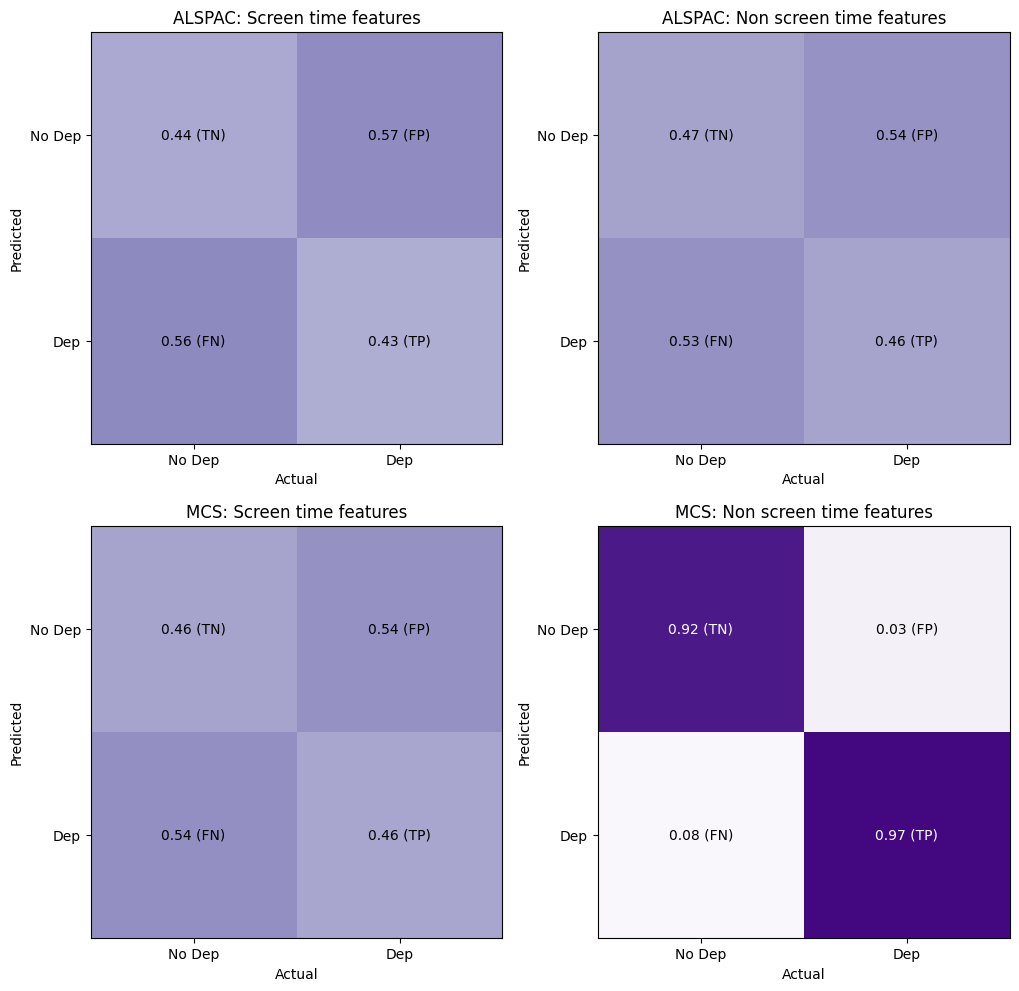

In [5]:
fig, ax = plt.subplots(2,2,figsize=(12,12), dpi=100)

for i, feature_group in enumerate(feature_groups):
    if i < 2:
        ax[0,i] = plot_conmat(feature_group.conmat, ax[0,i])
        ax[0,i].set(title = feature_group.study + ": " + feature_group.description)
    else:
        ax[1,i-2] = plot_conmat(feature_group.conmat, ax[1,i-2])
        ax[1,i-2].set(title = feature_group.study + ": " + feature_group.description)

plt.show()